In [2]:

# Do our imports and setup for this tutorial.
import os
import json
import logging
import copy
import tempfile
import glob
import time
import shutil
from concurrent.futures import ThreadPoolExecutor

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import nussl

start_time = time.time()

# seed this notebook
# (this seeds python's random, np.random, and torch.random)
nussl.utils.seed(0)



In [3]:
# define the building blocks
num_features = 129  # number of frequency bins in STFT
num_sources = 3  # how many sources to estimate
mask_activation = 'sigmoid'  # activation function for masks
num_audio_channels = 1  # number of audio channels

modules = {
    'mix_magnitude': {},
    'my_log_spec': {
        'class': 'AmplitudeToDB'
    },
    'my_norm': {
        'class': 'BatchNorm',
    },
    'my_mask': {
        'class': 'Embedding',
        'args': {
            'num_features': num_features,
            'hidden_size': num_features,
            'embedding_size': num_sources,
            'activation': mask_activation,
            'num_audio_channels': num_audio_channels,
            'dim_to_embed': [2, 3]  # embed the frequency dimension (2) for all audio channels (3)
        }
    },
    'my_estimates': {
        'class': 'Mask',
    },
}

In [4]:
def print_existing_modules():
    excluded = ['checkpoint', 'librosa', 'nn', 'np', 'torch', 'warnings']
    print('nussl.ml.modules contents:')
    print('--------------------------')
    existing_modules = [x for x in dir(nussl.ml.modules) if
                        x not in excluded and not x.startswith('__')]
    print('\n'.join(existing_modules))


print_existing_modules()

nussl.ml.modules contents:
--------------------------
Alias
AmplitudeToDB
BatchNorm
Concatenate
ConvolutionalStack2D
DualPath
DualPathBlock
Embedding
Expand
FilterBank
GaussianMixtureTorch
GroupNorm
InstanceNorm
LayerNorm
LearnedFilterBank
Mask
MelProjection
RecurrentStack
STFT
ShiftAndScale
Split
blocks
filter_bank


In [5]:

# define the topology
connections = [
    ['my_log_spec',    ['mix_magnitude',          ]],
    ['my_norm',        ['my_log_spec',            ]],
    ['my_mask',        ['my_norm',                ]],
    ['my_estimates',   ['my_mask', 'mix_magnitude']]
]



In [6]:
# define the outputs
output = ['my_estimates', 'my_mask']

In [9]:
# put it all together
config = {
    'modules': modules,
    'connections': connections,
    'output': output,
    'name': 'separation' # I added this
}

print(json.dumps(config, indent=2))

{
  "modules": {
    "mix_magnitude": {},
    "my_log_spec": {
      "class": "AmplitudeToDB"
    },
    "my_norm": {
      "class": "BatchNorm"
    },
    "my_mask": {
      "class": "Embedding",
      "args": {
        "num_features": 129,
        "hidden_size": 129,
        "embedding_size": 3,
        "activation": "sigmoid",
        "num_audio_channels": 1,
        "dim_to_embed": [
          2,
          3
        ]
      }
    },
    "my_estimates": {
      "class": "Mask"
    }
  },
  "connections": [
    [
      "my_log_spec",
      [
        "mix_magnitude"
      ]
    ],
    [
      "my_norm",
      [
        "my_log_spec"
      ]
    ],
    [
      "my_mask",
      [
        "my_norm"
      ]
    ],
    [
      "my_estimates",
      [
        "my_mask",
        "mix_magnitude"
      ]
    ]
  ],
  "output": [
    "my_estimates",
    "my_mask"
  ],
  "name": "separation"
}


In [10]:
model = nussl.ml.SeparationModel(config)
print(model)

SeparationModel(
  (layers): ModuleDict(
    (my_log_spec): AmplitudeToDB()
    (my_norm): BatchNorm(
      (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (my_mask): Embedding(
      (linear): Linear(in_features=129, out_features=387, bias=True)
    )
    (my_estimates): Mask()
  )
)
Number of parameters: 50312


In [11]:
mix_magnitude = torch.rand(1, 400, 129, 1)
data = {'mix_magnitude': mix_magnitude}
output = model(data)

In [12]:

output.keys()



dict_keys(['my_estimates', 'my_mask'])

In [13]:
output['my_estimates'].shape, output['my_mask'].shape

(torch.Size([1, 400, 129, 1, 3]), torch.Size([1, 400, 129, 1, 3]))

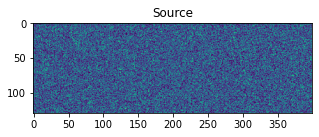

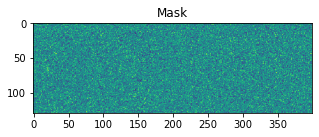

In [14]:
i = 0
plt.figure(figsize=(5, 5))
plt.imshow(output['my_estimates'][0, ..., 0, i].T.cpu().data.numpy())
plt.title("Source")
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(output['my_mask'][0, ..., 0, i].T.cpu().data.numpy())
plt.title("Mask")
plt.show()

In [15]:
with tempfile.NamedTemporaryFile(suffix='.pth', delete=True) as f:
    loc = model.save(f.name)
    reloaded_dict = torch.load(f.name)

    print(reloaded_dict.keys())

    new_model = nussl.ml.SeparationModel(reloaded_dict['config'])
    new_model.load_state_dict(reloaded_dict['state_dict'])

    print(new_model)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\ZAKNAF~1\\AppData\\Local\\Temp\\tmpz4_xzfkl.pth'